In [1]:
!pip install -q "monai-weekly[nibabel, tqdm]"
!pip install -q matplotlib
%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.4 MB/s eta 0:00:0000:0100:010m


In [2]:
!pip install einops

In [3]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR,UNETR,SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.5.dev2513
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ef083a32ccc13ee3937a4bd8acc12b9cdc174e18
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.47.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

In [ ]:
import os
import glob
import json

file_paths1 = glob.glob('/kaggle/input/brats2023-part-1/*')  
file_paths1.sort()

file_names1 = [os.path.basename(path) for path in file_paths1]  
file_names1.sort()

# Initializing the lists
t1c, t1n, t2f, t2w, label = [], [], [], [], []
num_files = len(file_paths1)


for i in range(num_files):
    t1c.append(os.path.join(file_paths1[i], file_names1[i] + '-t1c.nii'))
    t1n.append(os.path.join(file_paths1[i], file_names1[i] + '-t1n.nii'))
    t2f.append(os.path.join(file_paths1[i], file_names1[i] + '-t2f.nii'))
    t2w.append(os.path.join(file_paths1[i], file_names1[i] + '-t2w.nii'))
    label.append(os.path.join(file_paths1[i], file_names1[i] + '-seg.nii'))


file_list = []
for i in range(num_files):
    file_list.append({
        "image": [t1c[i], t1n[i], t2f[i], t2w[i]],  
        "label": label[i]
    })

file_json = {
    "training": file_list
}

file_path = '/kaggle/working/dataset.json'
with open(file_path, 'w') as json_file:
    json.dump(file_json, json_file, indent=4)


print(json.dumps({"training": file_list[:100]}, indent=4))


{
    "training": [
        {
            "image": [
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii"
            ],
            "label": "/kaggle/input/brats2023-part-1/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii"
        },
        {
            "image": [
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1c.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1n.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2f.nii",
                "/kaggle/input/brats2023-part-1/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2w.nii"
    

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp4kynt191


In [6]:
set_determinism(seed=0)

In [7]:
from monai.transforms import MapTransform

class ConvertLabels(MapTransform):
    """
    Convert single-channel BRATS segmentation labels into 3 binary channels:
    - Channel 0: Tumor Core (TC) = labels 1 (NCR) + 3 (ET)
    - Channel 1: Whole Tumor (WT) = labels 1 (NCR) + 2 (ED) + 3 (ET)
    - Channel 2: Enhancing Tumor (ET) = label 3 only
    """

    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # Tumor Core (TC) = NCR (1) + Enhancing Tumor (3)
            result.append(torch.logical_or(d[key] == 1, d[key] == 3))
            # Whole Tumor (WT) = NCR (1) + Edema (2) + Enhancing Tumor (3)
            result.append(torch.logical_or(torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 3))
            # Enhancing Tumor (ET) = label 3 only
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d


In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        ConvertLabels(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[96, 96, 96], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        
          ConvertLabels(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)



In [ ]:

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Task01_BrainTumour.tar: 7.09GB [08:29, 14.9MB/s]                                

2025-03-30 05:30:02,694 - INFO - Downloaded: /tmp/tmp4kynt191/Task01_BrainTumour.tar


2025-03-30 05:30:15,905 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-03-30 05:30:15,906 - INFO - Writing into directory: /tmp/tmp4kynt191.


In [ ]:
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd,
    Spacingd, RandSpatialCropd, RandFlipd, NormalizeIntensityd,
    RandScaleIntensityd, RandShiftIntensityd
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
from sklearn.model_selection import train_test_split
import json


dataset_path = "/kaggle/input/jsondata/dataset.json"
with open(dataset_path) as f:
    datalist = json.load(f)["training"]


train_files, val_files = train_test_split(datalist, test_size=0.2, random_state=42)

# Set deterministic behavior
set_determinism(seed=0)

# Define the transforms
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabels(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[96, 96, 96], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabels(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

# Create MONAI datasets
train_ds = Dataset(data=train_files, transform=train_transform)
val_ds = Dataset(data=val_files, transform=val_transform)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=3, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=3, pin_memory=True, persistent_workers=True)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")



Training samples: 500
Validation samples: 125


In [13]:
import nibabel as nib

label_path = val_files[0]["label"]
label_data = nib.load(label_path).get_fdata()
print("Raw Label Shape:", label_data.shape)

Raw Label Shape: (240, 240, 155)


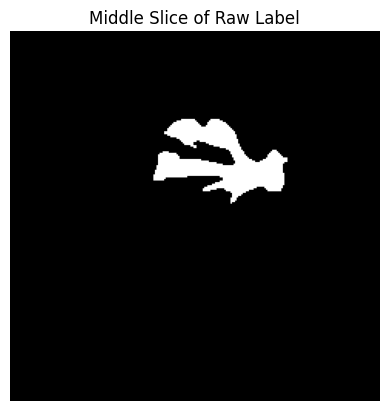

In [14]:
import matplotlib.pyplot as plt

plt.imshow(label_data[:, :, label_data.shape[2] // 2], cmap="gray")
plt.title("Middle Slice of Raw Label")
plt.axis("off")
plt.show()


In [15]:
import numpy as np

print("Unique labels in raw data:", np.unique(label_data))


Unique labels in raw data: [0. 1. 2. 3.]


In [ ]:
# Check the unique values in the label after the transformation
train_data_example = train_ds[66]  # Inspect the first item in the training dataset
label = train_data_example['label']


for i in range(label.shape[0]):  
    unique_vals = torch.unique(label[i])  
    print(f"Unique values in label channel {i}: {unique_vals}")


Unique values in label channel 0: tensor([0., 1.])
Unique values in label channel 1: tensor([0., 1.])
Unique values in label channel 2: tensor([0., 1.])


In [17]:
for i, region in enumerate(["Tumor Core", "Whole Tumor", "Enhancing Tumor"]):
    unique_vals = torch.unique(label[i])
    print(f"{region} (channel {i}): {unique_vals}")


Tumor Core (channel 0): tensor([0., 1.])
Whole Tumor (channel 1): tensor([0., 1.])
Enhancing Tumor (channel 2): tensor([0., 1.])


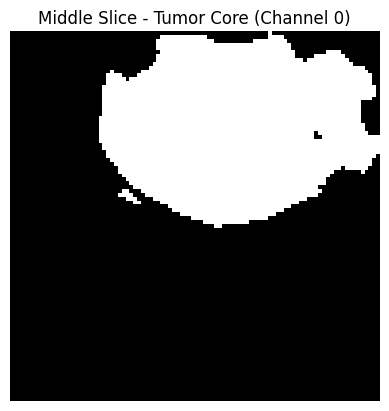

In [18]:
import matplotlib.pyplot as plt

plt.imshow(label[1, :, :, label.shape[3] // 3].numpy(), cmap="gray")
plt.title("Middle Slice - Tumor Core (Channel 0)")
plt.axis("off")
plt.show()


In [19]:
raw_label = train_data_example['label']
print(f"Raw Label: {torch.unique(raw_label)}")

Raw Label: tensor([0., 1.])


In [20]:
transform = ConvertLabels(keys=["label"])
transformed_data = transform({'label': torch.tensor(raw_label)})
print(f"Transformed Label shape: {transformed_data['label'].shape}")
for i, region in enumerate(["Tumor Core", "Whole Tumor", "Enhancing Tumor"]):
    print(f"Channel {i} ({region}): {torch.unique(transformed_data['label'][i])}")


<ipython-input-20-cbaef70ab651>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_data = transform({'label': torch.tensor(raw_label)})


Transformed Label shape: torch.Size([3, 3, 96, 96, 96])
Channel 0 (Tumor Core): tensor([0., 1.])
Channel 1 (Whole Tumor): tensor([0., 1.])
Channel 2 (Enhancing Tumor): tensor([0.])


In [ ]:

val_data_example = val_ds[5] 

print(f"Image shape: {val_data_example['image'].shape}")
print(f"Label shape: {val_data_example['label'].shape}")

Image shape: torch.Size([4, 240, 240, 155])
Label shape: torch.Size([3, 240, 240, 155])


Unique values in the raw label data: tensor([0., 1., 2., 3.], dtype=torch.float64)


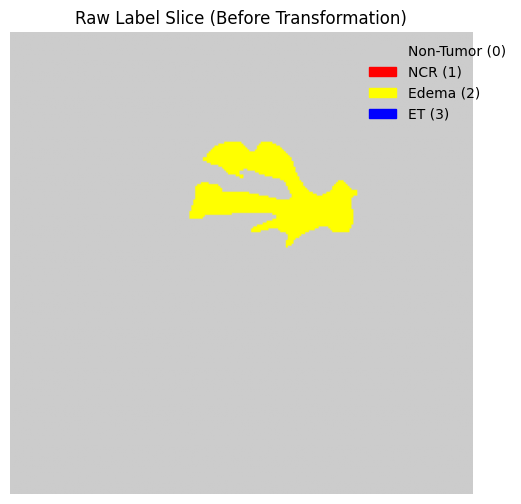

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.patches as mpatches


label_data = torch.tensor(label_data)  


print("Unique values in the raw label data:", torch.unique(label_data))

# Visualize a middle slice of the raw label data to visually inspect it
plt.figure(figsize=(12, 6))

# Selecting a middle slice 
slice_idx = label_data.shape[2] // 2


label_colors = {
    0: (0.8, 0.8, 0.8),  # Non-tumor: Light gray
    1: (1, 0, 0),        # Necrotic Tumor Core (NCR): Bright Red
    2: (1, 1, 0),        # Edema (ED): Bright Yellow
    3: (0, 0, 1),        # Enhancing Tumor (ET): Bright Blue
}


colored_label_data = np.zeros((label_data.shape[0], label_data.shape[1], 3))  

for label_value, color in label_colors.items():
    mask = label_data[:, :, slice_idx] == label_value
    colored_label_data[mask] = color

plt.imshow(colored_label_data)
plt.title("Raw Label Slice (Before Transformation)")
plt.axis('off')




handles = [
    mpatches.Patch(color=(0.8, 0.8, 0.8), label="Non-Tumor (0)"),
    mpatches.Patch(color=(1, 0, 0), label="NCR (1)"),
    mpatches.Patch(color=(1, 1, 0), label="Edema (2)"),
    mpatches.Patch(color=(0, 0, 1), label="ET (3)")
]

plt.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.1, 1), frameon=False)

plt.show()


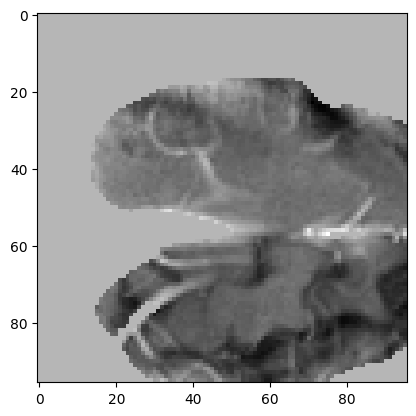

In [ ]:
image_slice = train_data_example['image'][0, :, :, slice_idx] 
plt.imshow(image_slice, cmap='gray')

Label shape: (240, 240, 155)


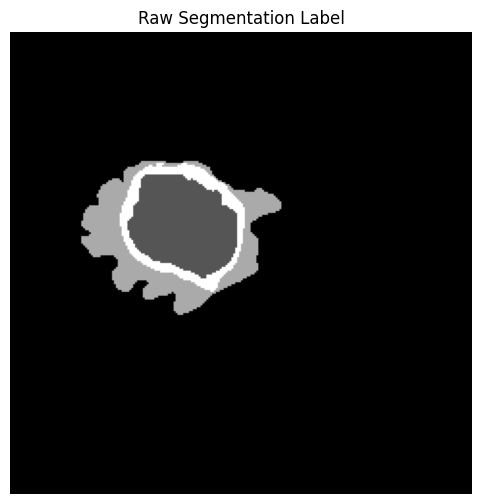

In [ ]:
import json
import nibabel as nib
import matplotlib.pyplot as plt


with open('/kaggle/input/jsondata/dataset.json', 'r') as f:
    dataset = json.load(f)


file_entry = dataset['training'][86] 
label_path = file_entry['label']  


label_nii = nib.load(label_path)
label_data = label_nii.get_fdata()  

print(f"Label shape: {label_data.shape}")

plt.figure(figsize=(18, 6))

#visualizing the middle slice
slice_idx = label_data.shape[2] // 2

plt.subplot(1, 1, 1)
plt.title("Raw Segmentation Label")
plt.imshow(label_data[:, :, slice_idx], cmap="gray")  #middle slice
plt.axis('off')  

plt.show()


Unique values in TC channel: tensor([0., 1.])
Unique values in WT channel: tensor([0., 1.])
Unique values in ET channel: tensor([0., 1.])
Enhancing Tumor (ET) channel has 44058 non-zero values.


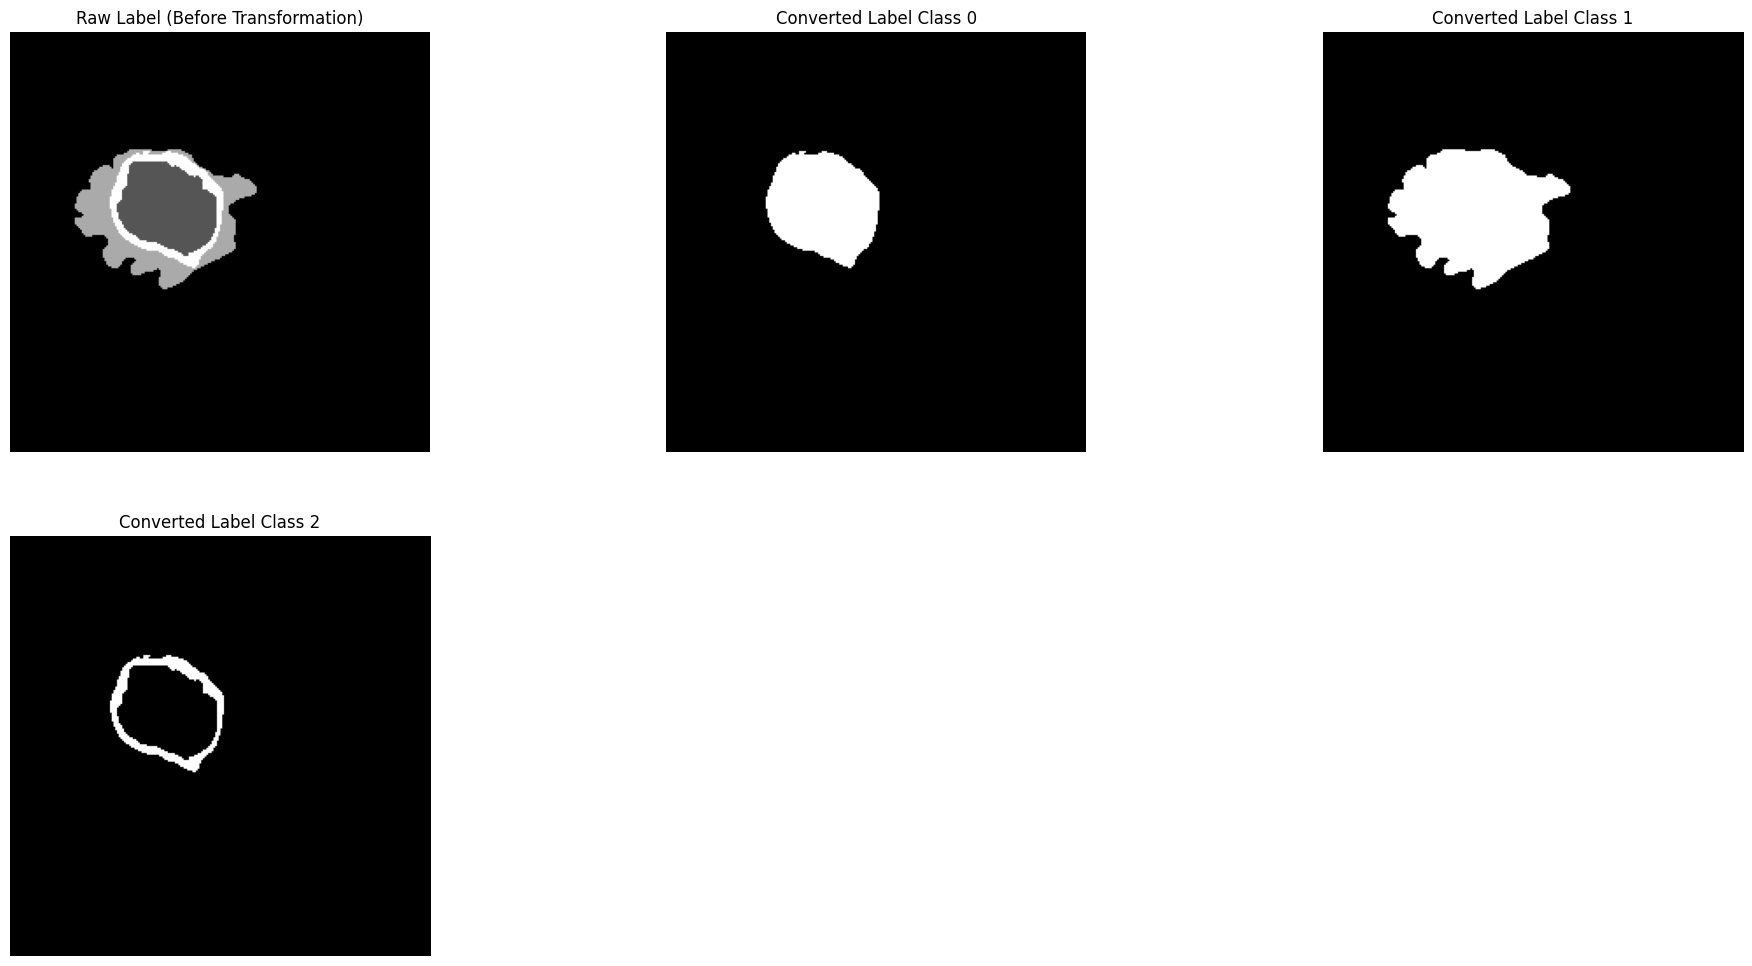

In [ ]:
import json
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import numpy as np
from monai.data import Dataset

with open('/kaggle/input/jsondata/dataset.json', 'r') as f:
    dataset = json.load(f)


file_entry = dataset['training'][86]  
label_path = file_entry['label']  
image_paths = file_entry['image']  


    


# Loading the label NIfTI file (raw labels)
label_nii = nib.load(label_path)
label_data = label_nii.get_fdata()  # Get the raw label data
label_data = torch.tensor(label_data) 

# Loading the image modalities (for visualization alongside labels)
image_nii = [nib.load(img_path) for img_path in image_paths]
image_data = [img.get_fdata() for img in image_nii]  # Get image data for each modality

# Defining the ConvertToMultiChannelBasedOnBratsClassesd transform
transform = ConvertLabels(keys=["label"])

# Preparing the data for the transform
data = {
    "image": image_data,  # List of images (modalities)
    "label": label_data,  # Raw label data
}


transformed_data = transform(data)
converted_label = transformed_data["label"]  # Get the converted label


print("Unique values in TC channel:", torch.unique(converted_label[0]))
print("Unique values in WT channel:", torch.unique(converted_label[1]))
print("Unique values in ET channel:", torch.unique(converted_label[2]))

# Check if the ET channel has any non-zero values
print(f"Enhancing Tumor (ET) channel has {torch.sum(converted_label[2] == 1)} non-zero values.")

# Visualize both raw label and converted label data side by side
plt.figure(figsize=(24, 12))

slice_idx = label_data.shape[2] // 2


plt.subplot(2, 3, 1)
plt.title("Raw Label (Before Transformation)")
plt.imshow(label_data[:, :, slice_idx], cmap="gray") 
plt.axis('off')


titles = ["Tumor Core (TC)", "Whole Tumor (WT)", "Enhancing Tumor (ET)"]
for i in range(3):  
    plt.subplot(2, 3, i + 2)
    plt.title(titles[i])
    plt.title(f"Converted Label Class {i}")
    plt.imshow(converted_label[i, :, :, slice_idx], cmap="gray") 
    plt.axis('off')

plt.show()


Image shape: torch.Size([4, 240, 240, 155])
Label shape: torch.Size([3, 240, 240, 155])


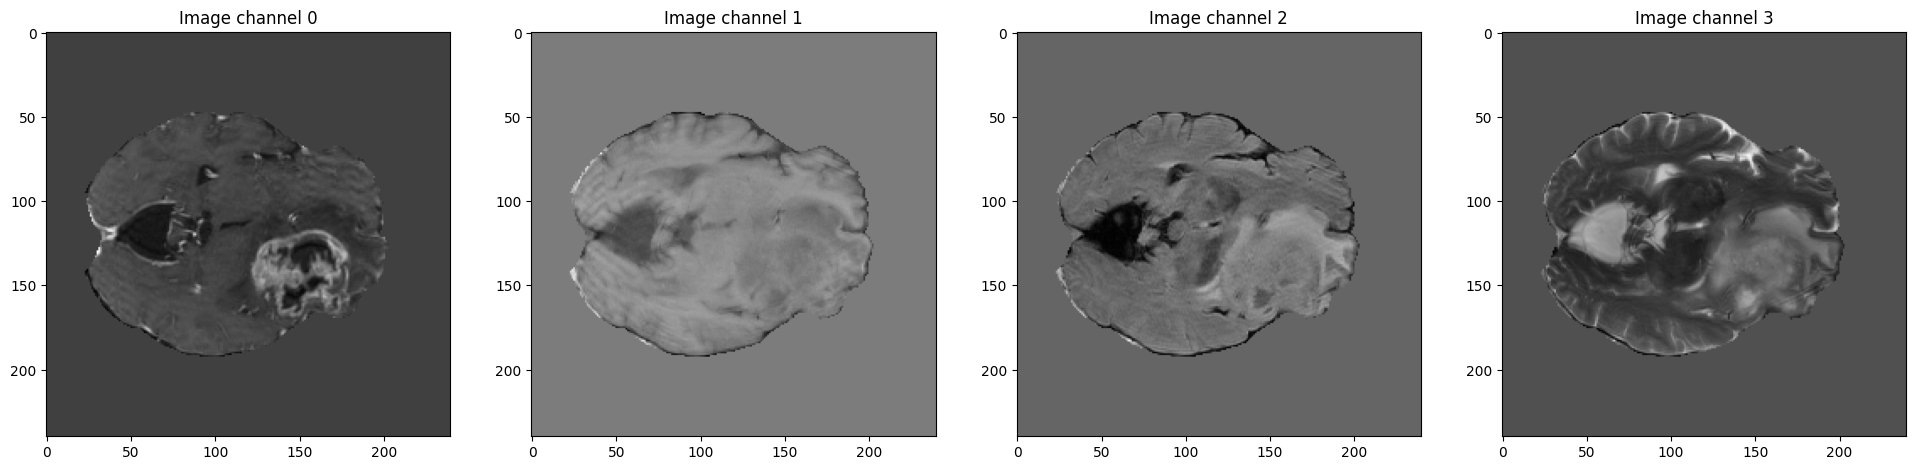

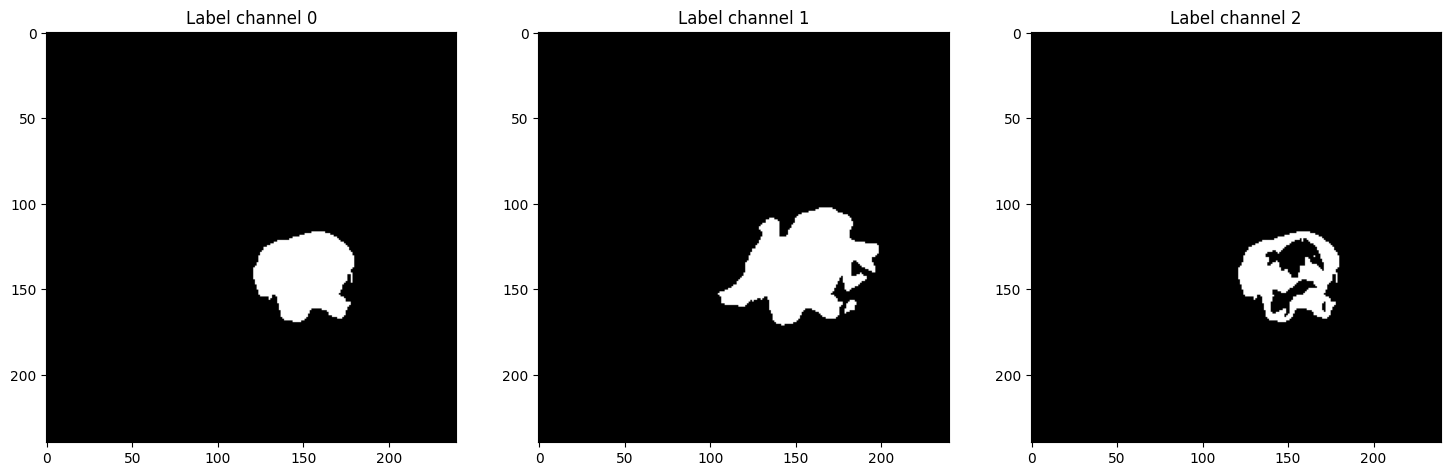

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming val_ds is already loaded
val_data_example = val_ds[42]  

print(f"Image shape: {val_data_example['image'].shape}")
print(f"Label shape: {val_data_example['label'].shape}")


image = val_data_example['image']
label = val_data_example['label']


plt.figure(figsize=(24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Image channel {i}")
    plt.imshow(image[i, :, :, 60].detach().cpu(), cmap="gray")  
plt.show()

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Label channel {i}")
    plt.imshow(label[i, :, :, 60].detach().cpu(), cmap="gray")  
plt.show()


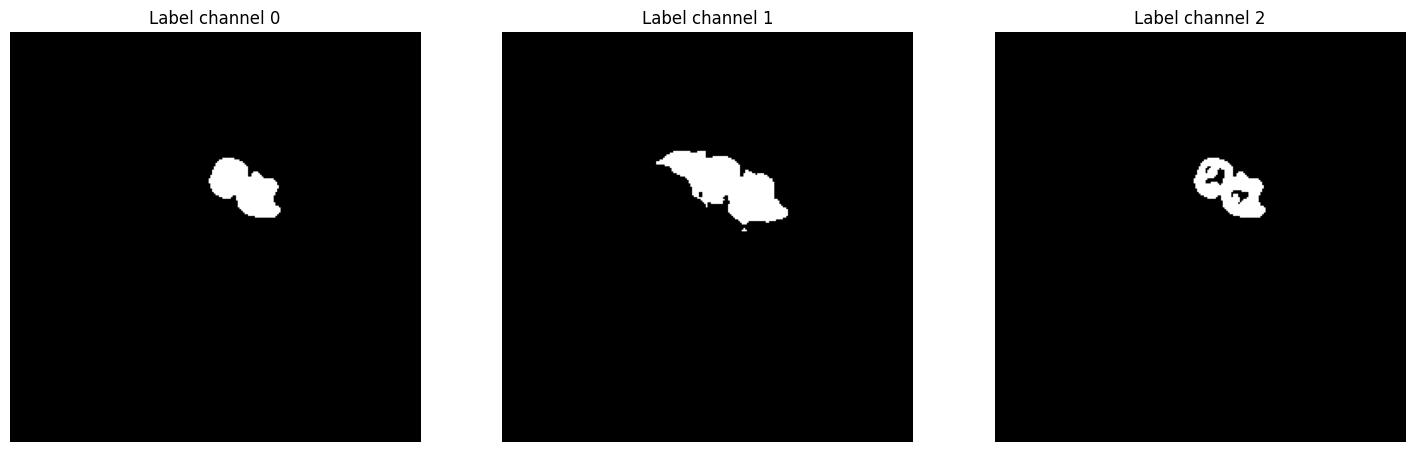

In [ ]:
import matplotlib.pyplot as plt

val_data_example = val_ds[66]
label = val_data_example['label']

plt.figure(figsize=(18, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Label channel {i}")
    plt.imshow(label[i, :, :, 60].detach().cpu(), cmap="gray")  
    plt.axis('off')  

plt.show()


image shape: torch.Size([4, 240, 240, 155])
label shape: torch.Size([3, 240, 240, 155])


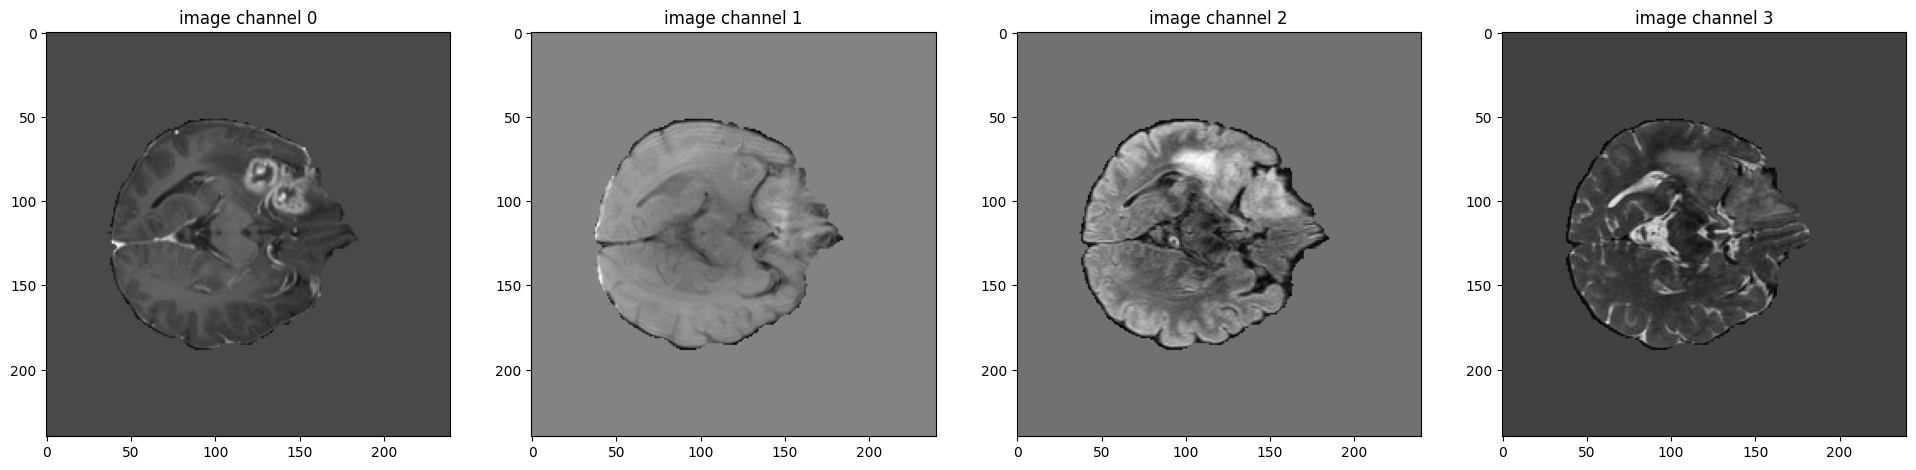

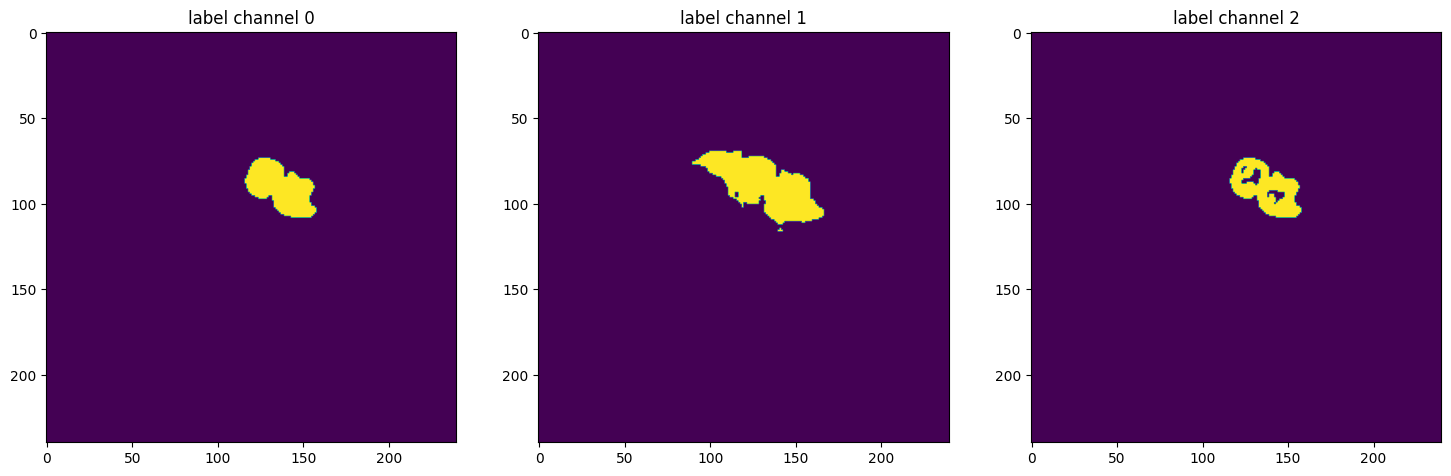

In [ ]:
import matplotlib.pyplot as plt


val_data_example = val_ds[66]


image_shape = val_data_example['image'].shape
label_shape = val_data_example['label'].shape

print(f"image shape: {image_shape}")
print(f"label shape: {label_shape}")


plt.figure("image", (24, 6))

# If the image has more than 3 dimensions (e.g., channels, height, width, depth)
if len(image_shape) == 4:
    for i in range(image_shape[0]): 
        plt.subplot(1, image_shape[0], i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
else:
   
    plt.imshow(val_data_example["image"][:, :, 60].detach().cpu(), cmap="gray")
    plt.title("image")
    
plt.show()


plt.figure("label", (18, 6))


if len(label_shape) == 4:
    for i in range(label_shape[0]):  
        plt.subplot(1, label_shape[0], i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
else:
    
    plt.imshow(val_data_example["label"][:, :, 60].detach().cpu())
    plt.title("label")

plt.show()


In [ ]:
max_epochs = 5
val_interval = 1
VAL_AMP = True


device = torch.device("cuda:0")
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=4,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,  
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


scaler = torch.cuda.amp.GradScaler()

torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
<ipython-input-30-03fb1a32e208>:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
import os
import time
import json
import torch
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch


best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]  
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

# Save training statistics for future reference
training_stats = {
    "best_metric": best_metric,
    "best_metric_epoch": best_metric_epoch,
    "best_metrics_epochs_and_time": best_metrics_epochs_and_time,
    "epoch_loss_values": epoch_loss_values,
    "metric_values": metric_values,
    "metric_values_tc": metric_values_tc,
    "metric_values_wt": metric_values_wt,
    "metric_values_et": metric_values_et,
    "total_time": total_time,
}

stats_path = os.path.join(root_dir, "training_stats.json")
with open(stats_path, "w") as f:
    json.dump(training_stats, f, indent=4)
print("Training statistics saved to", stats_path)


----------
epoch 1/5


<ipython-input-31-7105fcf5427b>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


1/250, train_loss: 0.9712, step time: 86.4580
2/250, train_loss: 0.9868, step time: 1.4955
3/250, train_loss: 1.0000, step time: 1.4978
4/250, train_loss: 0.9578, step time: 1.4944
5/250, train_loss: 0.9611, step time: 1.4971
6/250, train_loss: 0.8641, step time: 1.4953
7/250, train_loss: 0.8667, step time: 1.4966
8/250, train_loss: 0.9137, step time: 1.4942
9/250, train_loss: 0.7829, step time: 1.4966
10/250, train_loss: 0.9075, step time: 1.4998
11/250, train_loss: 0.9875, step time: 1.4971
12/250, train_loss: 0.9789, step time: 1.4965
13/250, train_loss: 0.9175, step time: 1.4972
14/250, train_loss: 0.9562, step time: 1.4979
15/250, train_loss: 0.9317, step time: 1.5055
16/250, train_loss: 0.9914, step time: 1.4946
17/250, train_loss: 0.9866, step time: 1.4957
18/250, train_loss: 0.8245, step time: 1.4949
19/250, train_loss: 0.9030, step time: 1.4956
20/250, train_loss: 0.9680, step time: 1.4978
21/250, train_loss: 0.9818, step time: 1.4958
22/250, train_loss: 0.9994, step time: 1.4

<ipython-input-30-03fb1a32e208>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


saved new best metric model
current epoch: 1 current mean dice: 0.2903 tc: 0.2895 wt: 0.4120 et: 0.1730
best mean dice: 0.2903 at epoch: 1
time consuming of epoch 1 is: 2083.2197
----------
epoch 2/5
1/250, train_loss: 0.7937, step time: 1.5194
2/250, train_loss: 0.5308, step time: 1.4957
3/250, train_loss: 0.7554, step time: 1.4955
4/250, train_loss: 0.6812, step time: 1.5108
5/250, train_loss: 0.6667, step time: 1.4998
6/250, train_loss: 0.6544, step time: 1.4976
7/250, train_loss: 0.7796, step time: 1.4965
8/250, train_loss: 0.6655, step time: 1.4956
9/250, train_loss: 0.9458, step time: 1.4949
10/250, train_loss: 0.6392, step time: 1.4958
11/250, train_loss: 0.5676, step time: 1.4950
12/250, train_loss: 0.6137, step time: 1.4996
13/250, train_loss: 0.8124, step time: 1.4979
14/250, train_loss: 0.7972, step time: 1.5023
15/250, train_loss: 0.6680, step time: 1.4972
16/250, train_loss: 0.3295, step time: 1.4945
17/250, train_loss: 0.8334, step time: 1.4950
18/250, train_loss: 0.7445,

In [32]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")


train completed, best_metric: 0.7816 at epoch: 5, total time: 10371.493196964264.


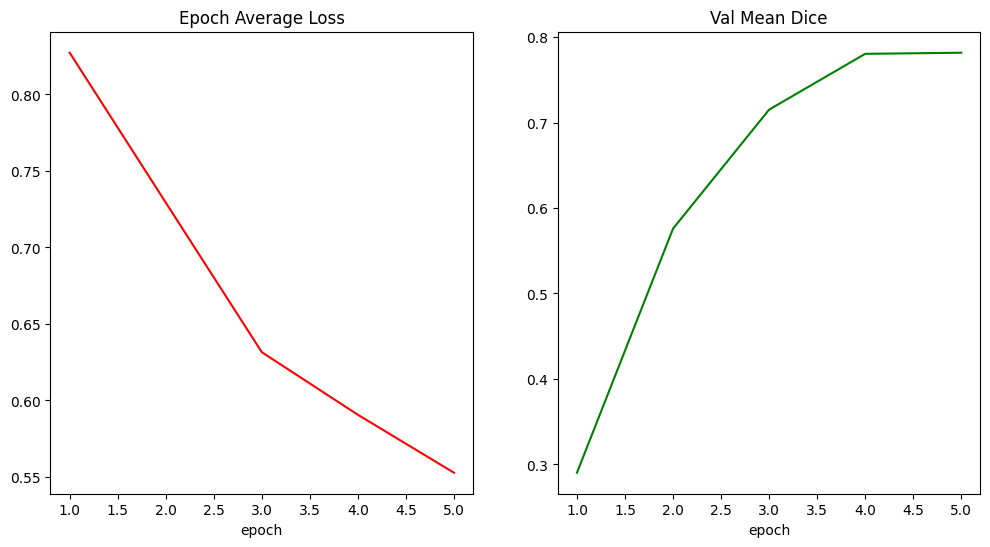

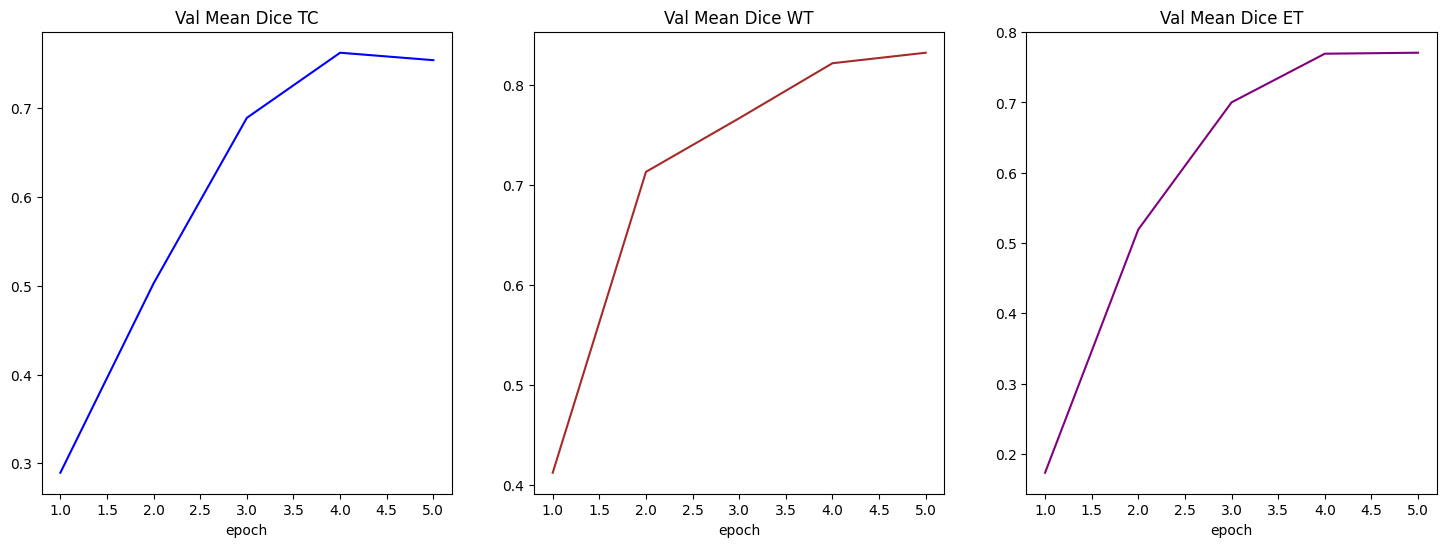

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

<ipython-input-34-0d606c482240>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
<ipython-

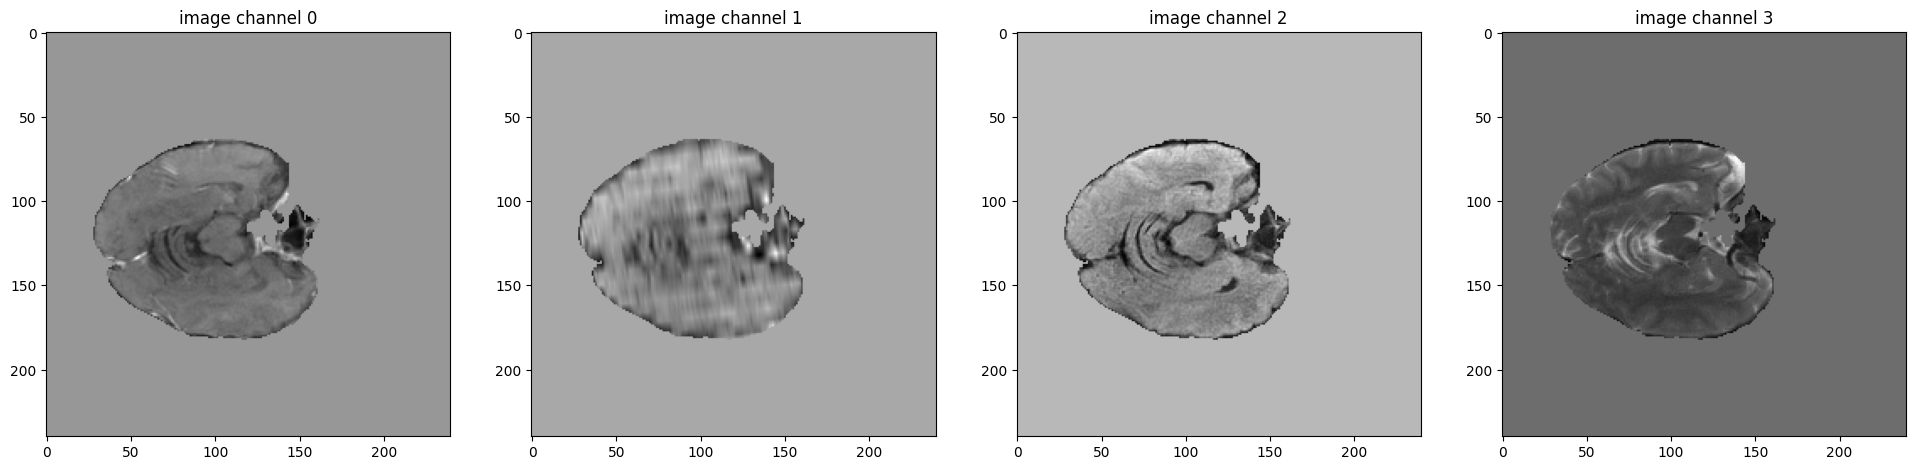

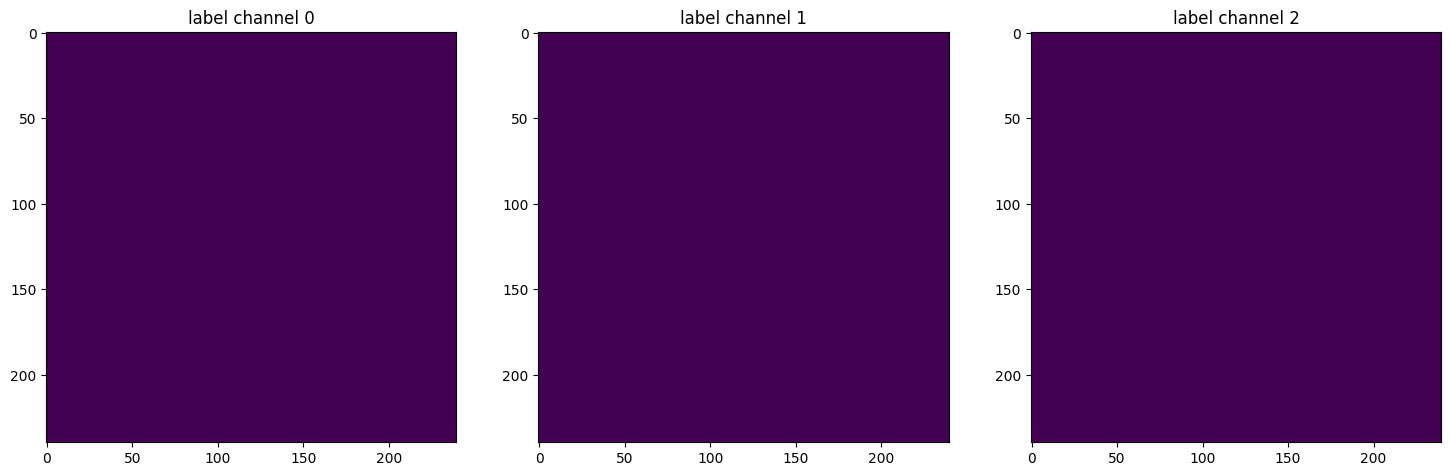

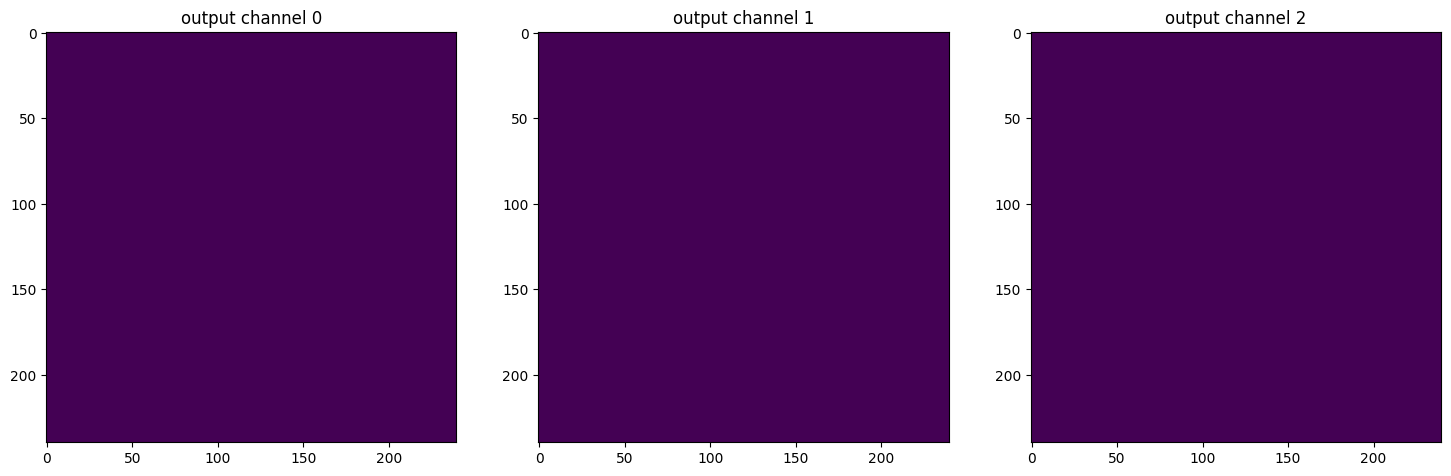

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[4]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[4]["image"][i, :, :, 72].detach().cpu(), cmap="gray")
    plt.show()
    
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[4]["label"][i, :, :, 72].detach().cpu())
    plt.show()
    
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 72].detach().cpu())
    plt.show()

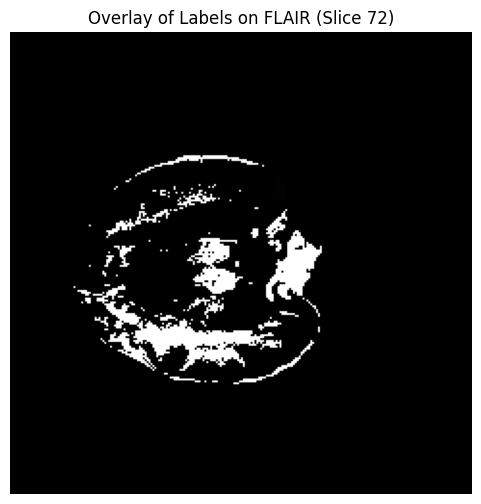

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_label_on_image(image, label, slice_idx, alpha=0.4):
    
    image = image[3] 
    slice_img = image[:, :, slice_idx]

    label_colors = {
        0: [255, 0, 0],    # TC - Red
        1: [0, 255, 0],    # WT - Green
        2: [0, 0, 255],    # ET - Blue
    }

    rgb_img = np.stack([slice_img]*3, axis=-1)  # Convert to RGB

    for i in range(label.shape[0]):
        mask = label[i, :, :, slice_idx]
        color = np.array(label_colors[i])
        for c in range(3):
            rgb_img[:, :, c] = np.where(mask > 0, 
                                        (1 - alpha) * rgb_img[:, :, c] + alpha * color[c],
                                        rgb_img[:, :, c])
    return rgb_img.astype(np.uint8)


image_np = val_ds[4]["image"].detach().cpu().numpy()
label_np = val_ds[4]["label"].detach().cpu().numpy()
overlay_img = overlay_label_on_image(image_np, label_np, slice_idx=72)


plt.figure(figsize=(6, 6))
plt.imshow(overlay_img)
plt.title("Overlay of Labels on FLAIR (Slice 72)")
plt.axis("off")
plt.show()


In [39]:
overlay_img.shape

(240, 240, 3)

ValueError: Argument filled must be 3-dimensional

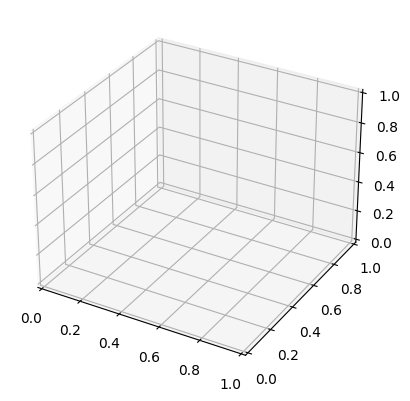

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(overlay_img.shape[0]):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(overlay_img[i])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Overlay Channel {i+1}')

    plt.show()


In [ ]:
!pip install ipyvolume


In [ ]:
import os
import nibabel as nib
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, Activations, AsDiscrete, EnsureType
from monai.data import decollate_batch
from tqdm import tqdm

# Create output directory
output_dir = os.path.join(root_dir, "predictions")
os.makedirs(output_dir, exist_ok=True)

model.eval()
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

with torch.no_grad():
    for idx, val_data in enumerate(tqdm(val_loader, desc="Running inference")):
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        
       
        for i, pred in enumerate(val_outputs):
            pred_np = pred.cpu().numpy().astype(np.uint8)
            file_name = f"pred_{idx:03d}.nii.gz"
            nib.save(nib.Nifti1Image(pred_np, affine=np.eye(4)), os.path.join(output_dir, file_name))


Running inference:   0%|          | 0/63 [00:00<?, ?it/s]<ipython-input-30-03fb1a32e208>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Running inference: 100%|██████████| 63/63 [25:35<00:00, 24.37s/it]


In [43]:
import pandas as pd

volume_stats = []

for idx, file in enumerate(sorted(os.listdir(output_dir))):
    if file.endswith(".nii.gz"):
        pred = nib.load(os.path.join(output_dir, file)).get_fdata()
        tc_vol = np.sum(pred[0])  # Tumor Core
        wt_vol = np.sum(pred[1])  # Whole Tumor
        et_vol = np.sum(pred[2])  # Enhancing Tumor
        volume_stats.append({
            "Sample": file,
            "TumorCore_Volume": int(tc_vol),
            "WholeTumor_Volume": int(wt_vol),
            "EnhancingTumor_Volume": int(et_vol),
        })

volume_df = pd.DataFrame(volume_stats)
volume_df.to_csv(os.path.join(root_dir, "tumor_volumes.csv"), index=False)
volume_df.head()


,Sample,TumorCore_Volume,WholeTumor_Volume,EnhancingTumor_Volume
0,pred_000.nii.gz,45437,81203,30843
1,pred_001.nii.gz,22382,92508,17003
2,pred_002.nii.gz,14942,54903,11397
3,pred_003.nii.gz,37576,122037,28489
4,pred_004.nii.gz,62991,156607,44540


In [44]:
dice_metric = DiceMetric(include_background=True, reduction="none")

sample_dice_scores = []

with torch.no_grad():
    for idx, val_data in enumerate(tqdm(val_loader)):
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

        dice = dice_metric(y_pred=val_outputs, y=decollate_batch(val_labels))
        dice_np = dice.cpu().numpy()[0]
        
        sample_dice_scores.append({
            "Sample": f"sample_{idx:03d}",
            "Dice_TC": dice_np[0],
            "Dice_WT": dice_np[1],
            "Dice_ET": dice_np[2],
        })

dice_df = pd.DataFrame(sample_dice_scores)
dice_df.to_csv(os.path.join(root_dir, "sample_dice_scores.csv"), index=False)
dice_df.head()


  0%|          | 0/63 [00:00<?, ?it/s]<ipython-input-30-03fb1a32e208>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 63/63 [24:38<00:00, 23.47s/it]


,Sample,Dice_TC,Dice_WT,Dice_ET
0,sample_000,0.957781,0.933798,0.877554
1,sample_001,0.895813,0.944634,0.883795
2,sample_002,0.811566,0.818469,0.882555
3,sample_003,0.960001,0.928727,0.922202
4,sample_004,0.792166,0.906458,0.899400


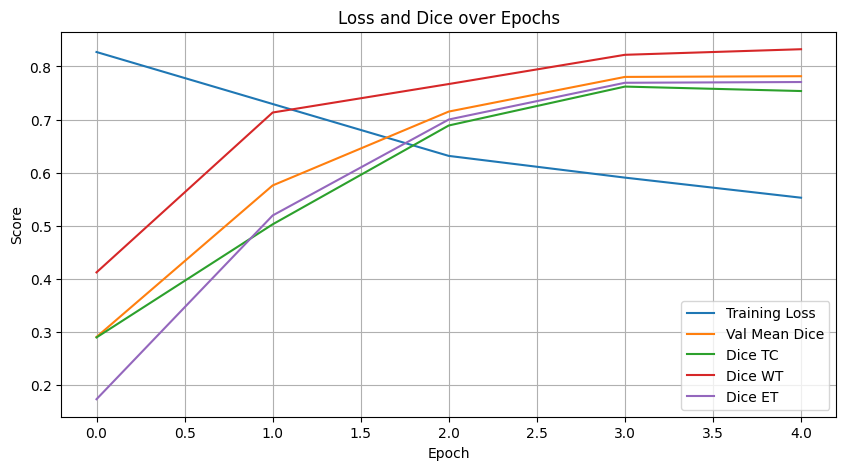

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_loss_values, label="Training Loss")
plt.plot(metric_values, label="Val Mean Dice")
plt.plot(metric_values_tc, label="Dice TC")
plt.plot(metric_values_wt, label="Dice WT")
plt.plot(metric_values_et, label="Dice ET")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Loss and Dice over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(root_dir, "training_plot.png"))
plt.show()


In [46]:
with open(os.path.join(root_dir, "summary.txt"), "w") as f:
    f.write(f"Best Dice Score: {best_metric:.4f} at Epoch: {best_metric_epoch}\n")
    f.write(f"Total Training Time: {total_time:.2f} sec\n")
    f.write("\nAverage Dice Scores Per Class:\n")
    f.write(f"  Tumor Core (TC): {np.mean(metric_values_tc):.4f}\n")
    f.write(f"  Whole Tumor (WT): {np.mean(metric_values_wt):.4f}\n")
    f.write(f"  Enhancing Tumor (ET): {np.mean(metric_values_et):.4f}\n")


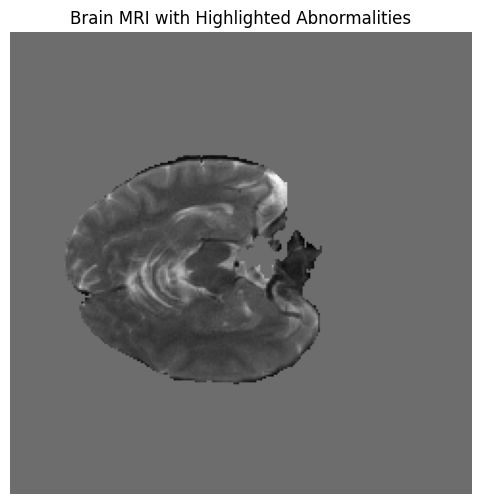

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def highlight_abnormality_overlay(image, label, slice_idx=72, alpha=0.5):
    
    # Use FLAIR channel (index 3) for base grayscale brain image
    base_slice = image[3, :, :, slice_idx]
    base_slice = (base_slice - np.min(base_slice)) / (np.max(base_slice) - np.min(base_slice))  # normalize
    rgb_base = np.stack([base_slice]*3, axis=-1)

    # Color map for each class: TC (Red), WT (Green), ET (Blue)
    class_colors = {
        0: [1, 0, 0],  # Red for Tumor Core
        1: [0, 1, 0],  # Green for Whole Tumor
        2: [0, 0, 1],  # Blue for Enhancing Tumor
    }

    overlay_img = rgb_base.copy()
    for i in range(label.shape[0]):
        mask = label[i, :, :, slice_idx]
        color = np.array(class_colors[i])
        for c in range(3):
            overlay_img[:, :, c] = np.where(
                mask > 0,
                (1 - alpha) * overlay_img[:, :, c] + alpha * color[c],
                overlay_img[:, :, c]
            )

    return overlay_img


image_np = val_ds[4]["image"].detach().cpu().numpy()
label_np = val_ds[4]["label"].detach().cpu().numpy()
highlighted_overlay = highlight_abnormality_overlay(image_np, label_np, slice_idx=72)

plt.figure(figsize=(6, 6))
plt.imshow(highlighted_overlay)
plt.title("Brain MRI with Highlighted Abnormalities")
plt.axis("off")
plt.show()


In [ ]:
from matplotlib import cm

def show_probability_heatmap(prob_map, image_slice, slice_idx=72, alpha=0.6):
    
    base_img = image_slice[:, :, slice_idx]
    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min())  # normalize

    prob_slice = prob_map[:, :, slice_idx]
    plt.imshow(base_img, cmap='gray')
    plt.imshow(prob_slice, cmap='jet', alpha=alpha)
    plt.colorbar(label="Probability")
    plt.title("Prediction Heatmap Overlay")
    plt.axis("off")
    plt.show()


In [ ]:

raw_output = model(val_input)[0].detach().cpu().numpy()
show_probability_heatmap(raw_output[2], image_np[3], slice_idx=72)


ValueError: spatial dimensions [2, 3, 4] of input image (spatial shape: torch.Size([240, 240, 155])) must be divisible by 2**5.

In [51]:
def plot_voxels_3d(mask, downsample=4, color='red'):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    downsampled = mask[::downsample, ::downsample, ::downsample]
    ax.voxels(downsampled, facecolors=color, edgecolor='k')
    ax.set_title("3D Tumor Structure")
    plt.show()


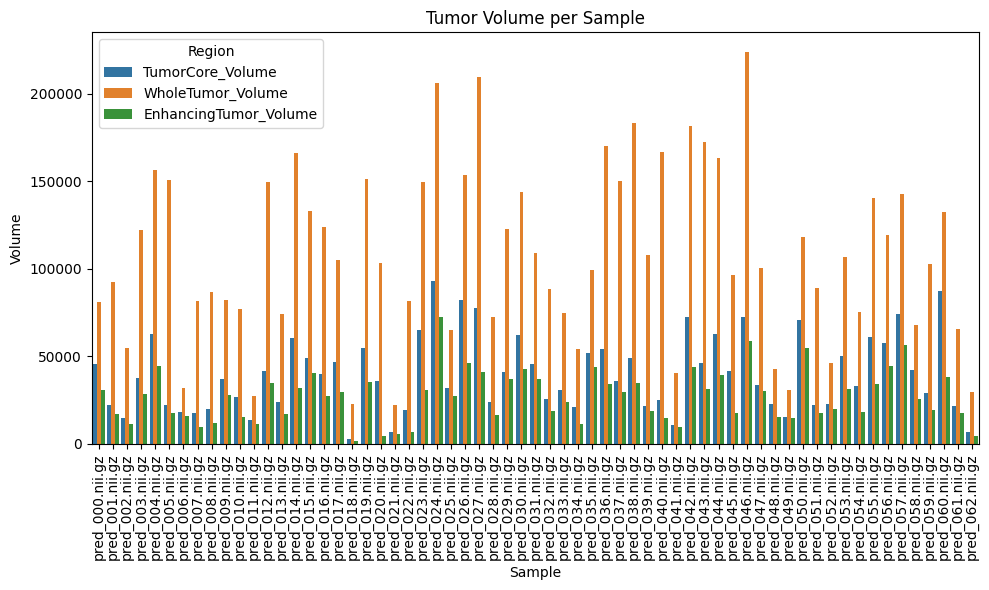

In [ ]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.barplot(data=volume_df.melt(id_vars=["Sample"], var_name="Region", value_name="Volume"),
            x="Sample", y="Volume", hue="Region")
plt.xticks(rotation=90)
plt.title("Tumor Volume per Sample")
plt.tight_layout()
plt.show()


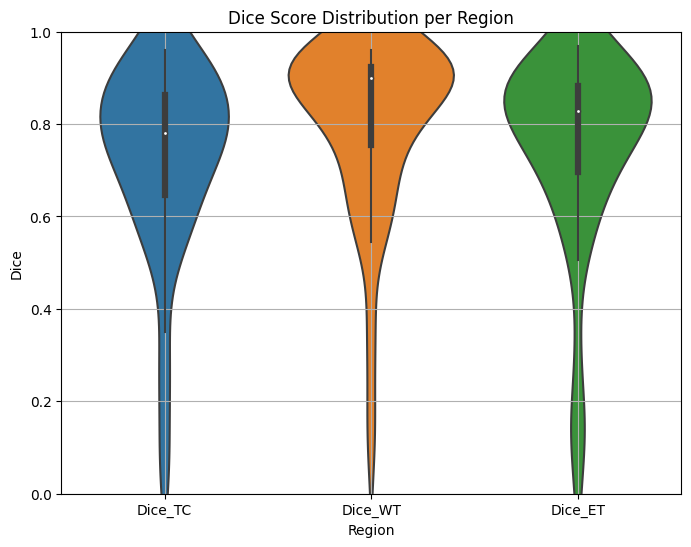

In [53]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=dice_df.melt(id_vars=["Sample"], var_name="Region", value_name="Dice"), 
               x="Region", y="Dice")
plt.title("Dice Score Distribution per Region")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [54]:
def compare_prediction_vs_gt(gt, pred, image, slice_idx=72):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image[3, :, :, slice_idx], cmap="gray")
    axs[0].imshow(gt[2, :, :, slice_idx], cmap="Reds", alpha=0.5)
    axs[0].set_title("Ground Truth (ET)")

    axs[1].imshow(image[3, :, :, slice_idx], cmap="gray")
    axs[1].imshow(pred[2, :, :, slice_idx], cmap="Blues", alpha=0.5)
    axs[1].set_title("Model Prediction (ET)")

    for ax in axs:
        ax.axis("off")
    plt.suptitle("Comparison of Ground Truth vs Prediction (ET)")
    plt.show()


In [ ]:
def visualize_multiclass_label(image_slice, label_slice):
    import matplotlib.patches as mpatches

    color_map = {
        0: (0, 0, 0),           # Background
        1: (0.4, 0.8, 0.2),     # Necrosis (Green)
        2: (1.0, 0.9, 0.4),     # Edema (Yellow)
        3: (0.4, 0.6, 1.0),     # Enhancing Tumor (Blue)
    }

  
    norm_img = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))
    rgb_image = np.stack([norm_img]*3, axis=-1)

    overlay = rgb_image.copy()
    for k, color in color_map.items():
        mask = (label_slice == k)
        for c in range(3):
            overlay[:, :, c][mask] = (1 - 0.5) * overlay[:, :, c][mask] + 0.5 * color[c]

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")

    legend_patches = [
        mpatches.Patch(color=color_map[1], label="Necrosis/Non-Enhancing"),
        mpatches.Patch(color=color_map[2], label="Edema/Invasion"),
        mpatches.Patch(color=color_map[3], label="Enhancing Tumor"),
    ]
    plt.legend(handles=legend_patches, loc="lower right")
    plt.title("Tumor Subregion Overlay (Multi-Class)")
    plt.show()


testing

In [ ]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from monai.transforms import Compose, Activations, AsDiscrete, EnsureType
from monai.inferers import sliding_window_inference

def load_model(model_path, device):
    model = SwinUNETR(
        img_size=(96, 96, 96),
        in_channels=4,
        out_channels=3,
        feature_size=48,
        use_checkpoint=False,
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model


post_trans = Compose([
    EnsureType(),
    Activations(sigmoid=True),
    AsDiscrete(threshold=0.5),
])


def predict_and_visualize(mri_4channel_nifti_path, model, device, slice_idx=72, save_path=None):
   
    img_nib = nib.load(mri_4channel_nifti_path)
    img_data = img_nib.get_fdata()  # Shape: (H, W, D, 4)
    img_data = np.transpose(img_data, (3, 0, 1, 2))  # To [C, H, W, D]

    input_tensor = torch.tensor(img_data).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = sliding_window_inference(input_tensor, roi_size=(96, 96, 96), sw_batch_size=1, predictor=model, overlap=0.5)
        pred = post_trans(pred[0]).cpu().numpy()  # Shape: [3, H, W, D]

    
    flair = img_data[3]  # FLAIR image
    flair_slice = flair[:, :, slice_idx]
    flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice))  # Normalize

    overlay = np.stack([flair_slice]*3, axis=-1)  # RGB base

    class_colors = {
        0: [1, 0, 0],  # TC - Red
        1: [0, 1, 0],  # WT - Green
        2: [0, 0, 1],  # ET - Blue
    }

    for i in range(3):
        mask = pred[i, :, :, slice_idx]
        for c in range(3):
            overlay[:, :, c] = np.where(
                mask > 0,
                (1 - 0.5) * overlay[:, :, c] + 0.5 * class_colors[i][c],
                overlay[:, :, c]
            )

  
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    axs[0].imshow(flair_slice, cmap="gray")
    axs[0].set_title("Input FLAIR Slice")
    axs[0].axis("off")

    for i, name in enumerate(["Tumor Core (TC)", "Whole Tumor (WT)", "Enhancing Tumor (ET)"]):
        axs[i+1].imshow(pred[i, :, :, slice_idx], cmap="gray")
        axs[i+1].set_title(name)
        axs[i+1].axis("off")

    axs[4].imshow(overlay)
    axs[4].set_title("Overlay")
    axs[4].axis("off")

    plt.tight_layout()
    plt.show()

   
    if save_path:
        pred_nifti = nib.Nifti1Image(pred.astype(np.uint8), affine=img_nib.affine)
        nib.save(pred_nifti, save_path)
        print(f"Saved predicted mask to {save_path}")


<ipython-input-56-a59bcd85b7d0>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


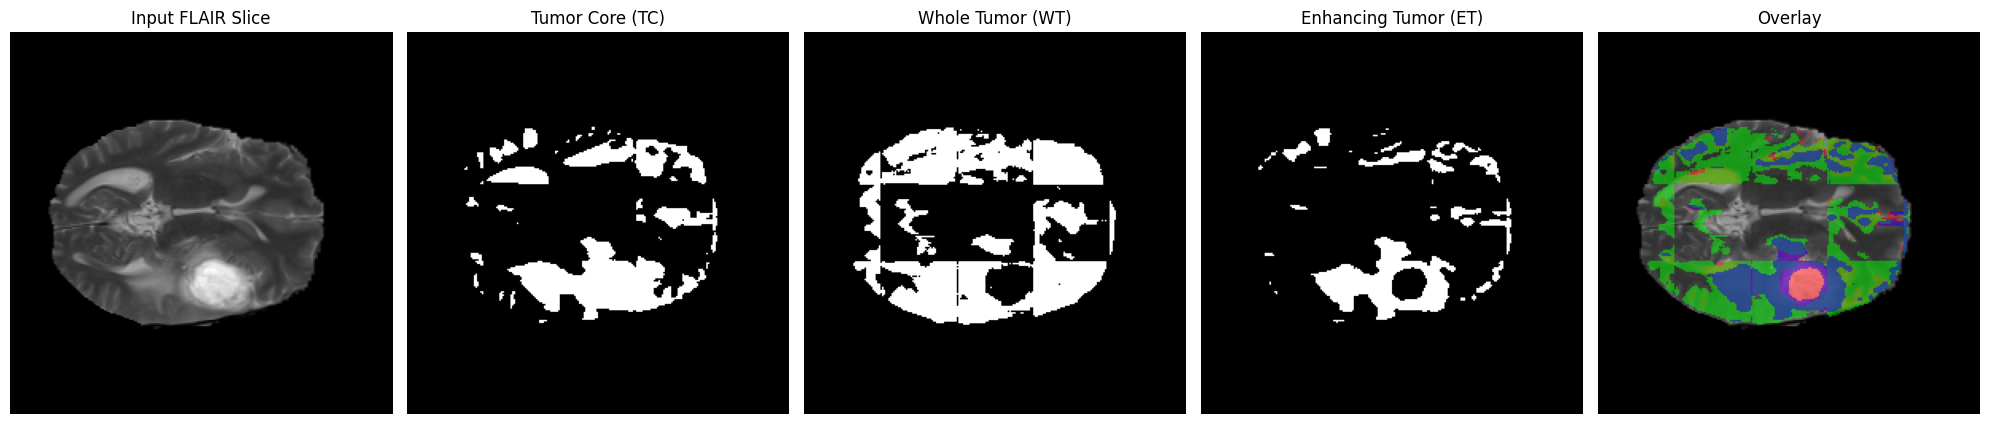

Saved predicted mask to prediction_output.nii.gz


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(root_dir, "best_metric_model.pth")  
model = load_model(model_path, device)


test_input_path = "/kaggle/working/tmp_saved_files/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz" 

predict_and_visualize(test_input_path, model, device, slice_idx=72, save_path="prediction_output.nii.gz")


In [ ]:
import torch
from monai.networks.nets import SwinUNETR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=4,
    out_channels=3,
    feature_size=48,
    use_checkpoint=False,  g
).to(device)


model.load_state_dict(torch.load("/kaggle/working/tmp_saved_files/best_metric_model.pth", map_location=device))

# Set to eval mode for inference
model.eval()


<ipython-input-70-59de0a7c5e11>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/tmp_saved_files/best_metric_model.pth", m

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(4, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature